<a href="https://colab.research.google.com/github/Ok3ks/Disso-COLD/blob/main/hyperpartisan_BERT_finetune_no_chunk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install transformers 
%pip install sklearn
%pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#from sklearn.datasets import fetch_20newsgroups #encountered issues SSLCertificationError with this 
from datasets import load_dataset, load_metric
import os
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding,get_scheduler
from torch.optim import AdamW

from spacy import tokenizer
from spacy.lang.en import English
import torch
from torch.utils.data import DataLoader
from utils import RoBERT_Model,ToBERT_Model
import json
import matplotlib.pyplot as plt

In [3]:
accuracy = load_metric('accuracy'); f1_score = load_metric('f1'); perplexity = load_metric('perplexity')

In [4]:
hyperpartisan_dataset = load_dataset("hyperpartisan_news_detection", "bypublisher") #Not stripped of headers and footers
hyperpartisan_dataset.keys()

  0%|          | 0/2 [00:00<?, ?it/s]

dict_keys(['train', 'validation'])

In [5]:
#change to bypublisher because byarticle has no test set.
hyperpartisan_train = hyperpartisan_dataset['train']
hyperpartisan_valid = hyperpartisan_dataset['validation']

hyperpartisan_train = hyperpartisan_train.shuffle(seed = 32)
hyperpartisan_test = hyperpartisan_valid.shuffle(seed = 32)

With huggingface

DOCUMENTS LESS THAN 300

In [6]:
#Should work once then modularize

max_input_length = 300 #Vary after obtaining end to end result
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, max_length = max_input_length)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) #to pad sequences


def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, max_length=max_input_length)

def compute_metrics(eval_pred):
    predictions, label = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    return f1_score.compute(predictions = predictions, references = label)

def hp_space(trial):

  return {"per_device_train_batch_size": trial.suggest_discrete_uniform("per_device_train_batch_size", 8,32,8)
        ,"learning_rate": trial.suggest_float("learning_rate", 0.0001,0.0005, log = True)
        ,"num_train_epochs": trial.suggest_int("num_train_epochs",1,10)
  }

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [7]:
hyperpartisan_train = hyperpartisan_train.select(range(10000)) #inconclusive because of nature of dataset
hyperpartisan_test = hyperpartisan_test

In [8]:
int_labels_train = {i: 1 if x == True else 0 for i,x in enumerate(hyperpartisan_train['hyperpartisan'])}
#int_labels_eval = {i: 1 if x == True else 0 for i,x in enumerate(hyperpartisan_eval['hyperpartisan'])}
int_labels_test = {i: 1 if x == True else 0 for i,x in enumerate(hyperpartisan_valid['hyperpartisan'])}

In [9]:
hyperpartisan_train = hyperpartisan_train.map(tokenize)
hyperpartisan_test = hyperpartisan_test.map(tokenize)

  0%|          | 0/600000 [00:00<?, ?ex/s]

EFFECT OF FINETUNING (with varying number of training files)

In [10]:
hyperpartisan_train = hyperpartisan_train.add_column("labels", int_labels_train.values())
hyperpartisan_test = hyperpartisan_test.add_column("labels", int_labels_test.values())

In [11]:
#Problems with finetuning with limited number of training files, is training set is unbalanced
#Less knowledge for neural network to learn from 
#Why not investigate the definition of what a chunk is, and use different pretraining objective e.g BERT,Roberta
#Problem with finetuning with long document is document input are limited in length, therefore learning across text documents is unbalanced

#Only way around finetuning on text document is to carefully analyse the training set and long documents.

(array([5024.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4976.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

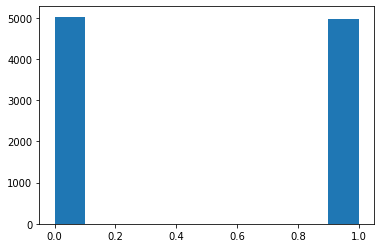

In [12]:
#Insight into the distribution of the dataset
plt.hist(hyperpartisan_train['labels'])

In [13]:
from sklearn.model_selection import KFold

In [14]:
fold = KFold(n_splits = 5)
this_set = fold.split(hyperpartisan_train['text'])

fold_train = []
fold_eval = []

for i,j in this_set:
  fold_train.append(hyperpartisan_train.select(i))
  fold_eval.append(hyperpartisan_train.select(j))

In [17]:
#for multi-class classification
#labels = hyperpartisan_train["label"]
#num_labels = len(labels)
#labels2id, id2labels = dict(),dict()
#for i,label in enumerate(labels):
    #labels2id[label] = i
    #id2labels[i] = label

def bert_init():
  return (BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, max_length = max_input_length))

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, max_length = max_input_length)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) #to pad sequences

#default training arguments 
training_args = TrainingArguments(output_dir="./results", per_device_train_batch_size=16, 
                                  evaluation_strategy= "epoch", per_device_eval_batch_size=16, num_train_epochs=5,weight_decay=0.01)

#fine-tuning model
trainer = Trainer(model = model,
              args = training_args,
              train_dataset= fold_train[1],
              eval_dataset= fold_eval[1],
              tokenizer= tokenizer,
              data_collator=data_collator,
              compute_metrics= compute_metrics)

#searching for best hyperparameters
trainer.train()

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_length": 300,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_

Epoch,Training Loss,Validation Loss,F1
1,0.310400,0.242743,0.902148
2,0.182800,0.297656,0.911794
3,0.083900,0.359108,0.922401
4,0.031100,0.487304,0.919132
5,0.004800,0.568527,0.919132


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: bias, hyperpartisan, url, text, published_at, title. If bias, hyperpartisan, url, text, published_at, title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/token

TrainOutput(global_step=2500, training_loss=0.12259795532226563, metrics={'train_runtime': 2672.5801, 'train_samples_per_second': 14.967, 'train_steps_per_second': 0.935, 'total_flos': 6166665360000000.0, 'train_loss': 0.12259795532226563, 'epoch': 5.0})

In [18]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: bias, hyperpartisan, url, text, published_at, title. If bias, hyperpartisan, url, text, published_at, title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 16


{'eval_loss': 0.5685266256332397,
 'eval_f1': 0.9191321499013807,
 'eval_runtime': 38.5146,
 'eval_samples_per_second': 51.928,
 'eval_steps_per_second': 3.246,
 'epoch': 5.0}

In [ ]:
trainer.predict(hyperpartisan_test)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: bias, hyperpartisan, url, text, published_at, title. If bias, hyperpartisan, url, text, published_at, title are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 600000
  Batch size = 16


In [ ]:
#display result 
#display confusion matrix


Value(dtype='int64', id=None)